In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload `kaggle.json`


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"satchibaghla","key":"3e1c74debb59372a257006d71ddba3f4"}'}

In [5]:
# Make a Kaggle directory and move the kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Intel Image Classification dataset from Kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

# Unzip the dataset
!unzip intel-image-classification.zip


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  intel-image-classification.zip
replace seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 


**STEP 1: Data Loading and Visualization**<br>Use Keras’ ImageDataGenerator to load images and apply augmentation for better generalization.


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to train and test directories
train_dir = 'seg_train/seg_train'
test_dir = 'seg_test/seg_test'

# Set up ImageDataGenerator for training and testing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                   rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
train_data = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', subset='training')
validation_data = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', subset='validation')

# Load test data
test_data = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Explanation:

ImageDataGenerator: This is used to load images from the directory and apply preprocessing (in this case, just rescaling).<br>
flow_from_directory: Loads images from the directory and assigns labels based on folder names.<br>
We visualize 9 random images from the training set using matplotlib.

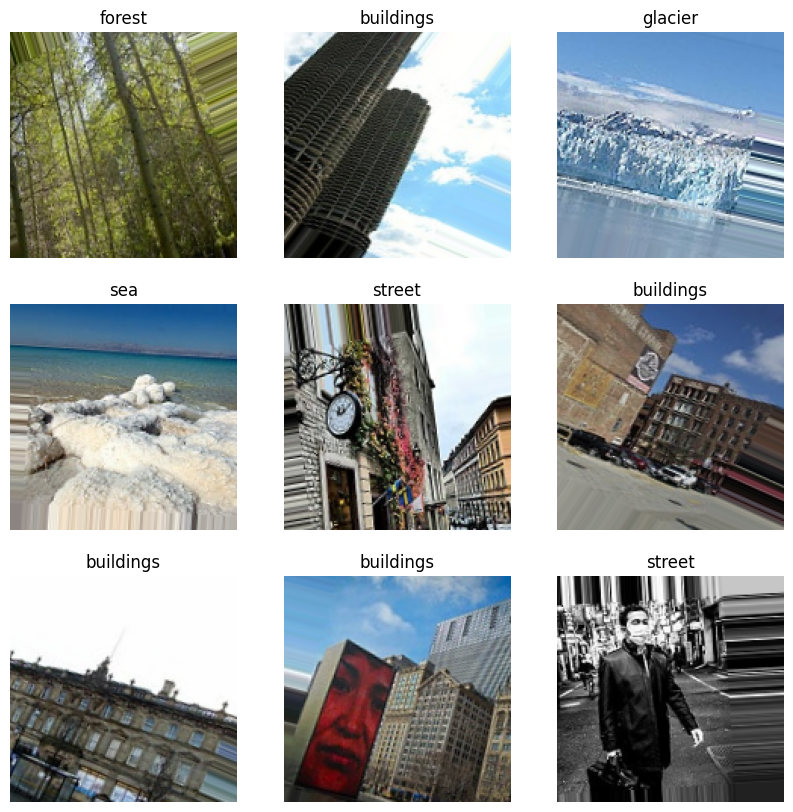

In [7]:
import matplotlib.pyplot as plt
import numpy as np

class_names = list(train_data.class_indices.keys())

# Retrieve a batch of images and labels from the training data
images, labels = next(train_data)

# Plot some of the images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.show()


**STEP 2: Model Architecture**<br>
Define a CNN architecture with convolutional layers, max pooling, batch normalization, and dropout.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes in the dataset
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 74, 74, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                        

Explanation:

We use Conv2D layers with ReLU activation, followed by MaxPooling2D to reduce spatial dimensions.<br>
BatchNormalization helps in stabilizing and speeding up training.<br>
The fully connected (dense) layers at the end allow the model to make predictions based on the learned features.<br>
We use softmax activation in the final layer since this is a multi-class classification problem.<br>

**STEP 3: Model Training**<br>
Train the model on the training data and validate it on the validation data.

In [9]:
# Train the model with training and validation data
history = model.fit(
    train_data,
    validation_data=validation_data,
    steps_per_epoch=train_data.samples // 32,
    validation_steps=validation_data.samples // 32,
    epochs=20
)


Epoch 1/20
350/350 [==============================] - 96s 270ms/step - loss: 5.4759 - accuracy: 0.4294 - val_loss: 2.4049 - val_accuracy: 0.3825
Epoch 2/20
350/350 [==============================] - 94s 268ms/step - loss: 1.5079 - accuracy: 0.5143 - val_loss: 1.2872 - val_accuracy: 0.5269
Epoch 3/20
350/350 [==============================] - 94s 268ms/step - loss: 1.1509 - accuracy: 0.5699 - val_loss: 0.9456 - val_accuracy: 0.6498
Epoch 4/20
350/350 [==============================] - 93s 266ms/step - loss: 1.0941 - accuracy: 0.5932 - val_loss: 0.9199 - val_accuracy: 0.6494
Epoch 5/20
350/350 [==============================] - 93s 267ms/step - loss: 1.0641 - accuracy: 0.6050 - val_loss: 0.9405 - val_accuracy: 0.6724
Epoch 6/20
350/350 [==============================] - 93s 266ms/step - loss: 1.0376 - accuracy: 0.6204 - val_loss: 1.0035 - val_accuracy: 0.6455
Epoch 7/20
350/350 [==============================] - 93s 265ms/step - loss: 1.0051 - accuracy: 0.6234 - val_loss: 1.0657 - val_ac

model.fit() trains the CNN using the training.

**STEP 4: Model Evaluation**<br>
Evaluate the model on the test set and plot training and validation accuracy/loss.

94/94 [==============================] - 4s 43ms/step - loss: 1.0381 - accuracy: 0.6960
Test accuracy: 0.6959999799728394


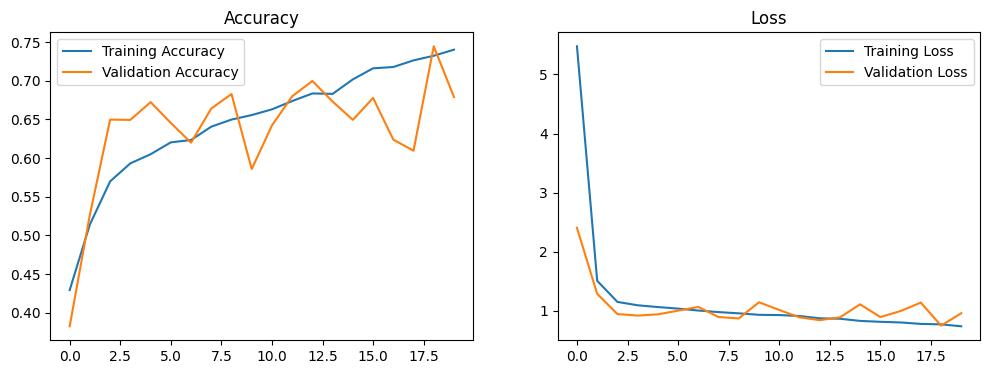

In [10]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc}")

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


We evaluate the trained model on the test data to get the test accuracy.<br>
The accuracy and loss curves help visualize the model's performance across epochs.

**STEP 5: Display Confusion Matrix**<br>
Analyze the model’s predictions on the test set with a confusion matrix.

94/94 [==============================] - 4s 44ms/step


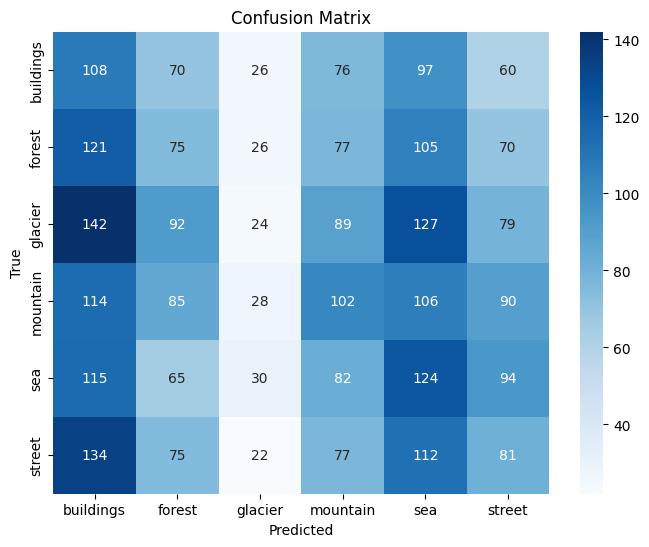

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on test data
y_pred = np.argmax(model.predict(test_data), axis=-1)
y_true = test_data.classes

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


**STEP 5: Optimization**<br>
1.  Experiment with Data Augmentation<br>
2.  Fine-Tune Hyperparameters<br>
    2.1. Adjust Learning Rate and Batch Size<br>
    2.2. Modify the Number of Filters



In [ ]:
# Define ImageDataGenerator with additional augmentation techniques
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Rescale pixel values
    validation_split=0.2,      # Split for validation set
    rotation_range=40,        # Random rotations
    width_shift_range=0.2,    # Randomly shift images horizontally
    height_shift_range=0.2,   # Randomly shift images vertically
    shear_range=0.2,          # Shear transformations
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Randomly flip images
    fill_mode='nearest'       # Fill mode for new pixels
)

# Load training and validation data with the updated augmentation
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model with a different learning rate
learning_rate = 1e-4  # Reduced learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Re-train the model with a different batch size
history = model.fit(
    train_data,
    validation_data=validation_data,
    steps_per_epoch=train_data.samples // 32,  # Adjust this according to the new batch size
    validation_steps=validation_data.samples // 32,
    epochs=20
)


In [ ]:
# Define a new CNN model with different filter sizes
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),  # Increased filters
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),  # Increased filters
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu'),  # Increased filters
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),  # Increased dense layer size
    Dropout(0.5),
    Dense(6, activation='softmax')  # Output layer for 6 classes
])

# Compile the new model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Re-train the model
history = model.fit(
    train_data,
    validation_data=validation_data,
    steps_per_epoch=train_data.samples // 32,
    validation_steps=validation_data.samples // 32,
    epochs=20
)
